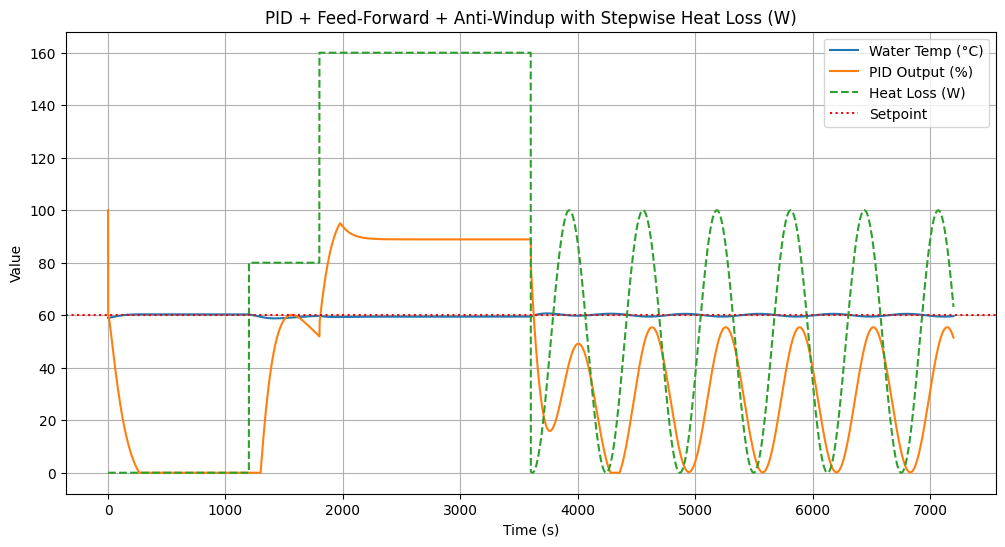

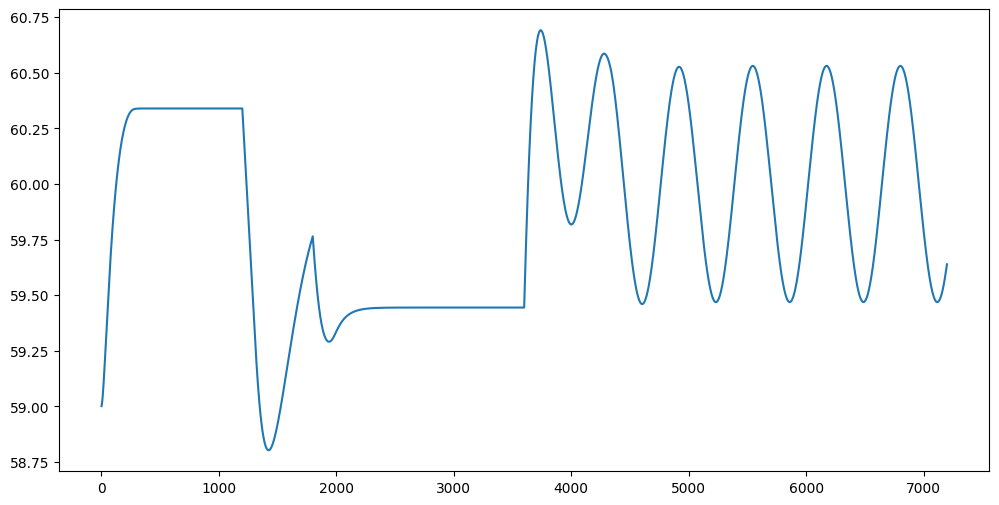

In [57]:
import matplotlib.pyplot as plt
import math
# ----------------------
# Water Heater Parameters
# ----------------------
m = 20.0           # kg water
c = 4186.0         # J/kg°C
heater_max = 1800.0 # W max
Tset = 60.0

# ----------------------
# PID Parameters
# ----------------------
Kp = 0.5
Ki = 0.0019
Kd = 5
I_min, I_max = -0.5, 0.5  # anti-windup clamp

I = 0.0
last_error = 0.0

# ----------------------
# Simulation settings
# ----------------------
dt = 1.0
sim_time = 7200
steps = int(sim_time / dt)

# ----------------------
# Logs
# ----------------------
temps = []
u_curve = []
heater_power_curve = []
loss_curve = []
times = []

# initial water temp
T = 59.0

tau = 18.0  # seconds, plant time constant
P_eff = 0.0 # effective heater power after inertia

# ----------------------
# Simulation loop
# ----------------------
for step in range(steps):
    t = step * dt

    # ---------- Heat loss in W (stepwise) ----------
    if t < 1200:
        loss_watts = 0   # first 200 s, moderate loss
    elif t < 1800:
        loss_watts = 800
    elif t < 3600:
        loss_watts = 1600   # next 200 s, stronger loss
    else:
        loss_watts = (math.sin(t/100)+1) * 500   # after 400 s, very strong loss
    loss_curve.append(loss_watts/10)

    # ---------- PID feed-forward ----------
    # static guess, for example 200 W
    u_ff = 200 / heater_max
    u_ff = max(0, min(1, u_ff))

    # ---------- PID ----------
    error = Tset - T
    P = Kp * error
    I += Ki * error * dt
    I = max(I_min, min(I_max, I))  # anti-windup
    D = Kd * (error - last_error) / dt
    last_error = error

    u = u_ff + P + I + D
    u = max(0, min(1, u))  # clamp 0..1
    u_curve.append(u * 100)


    heater_power = u * heater_max
    heater_power_curve.append(heater_power/10)
    P_eff += (heater_power - P_eff) * dt / tau

    # ---------- Plant ----------
    dT = (P_eff - loss_watts) * dt / (m * c)
    T += dT
    temps.append(T)
    times.append(t)

# ----------------------
# Plot everything
# ----------------------
plt.figure(figsize=(12,6))
plt.plot(times, temps, label="Water Temp (°C)")
plt.plot(times, u_curve, label="PID Output (%)")
# plt.plot(times, heater_power_curve, label="Heater Power (W)")
plt.plot(times, loss_curve, linestyle='--', label="Heat Loss (W)")
plt.axhline(Tset, color='r', linestyle=':', label="Setpoint")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("PID + Feed-Forward + Anti-Windup with Stepwise Heat Loss (W)")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(times, temps, label="Water Temp (°C)")
plt.show()